## **Problem 6: Generative Adversarial Networks (GAN)**

 # Question 1:

# Part 1 & 2.

Ep 1/25:   0%|          | 0/390 [00:15<?, ?it/s]

Epoch [1/25] | D 0.479 | G 3.236


Ep 2/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25] | D 0.577 | G 3.801


Ep 3/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25] | D 0.677 | G 3.464


Ep 4/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25] | D 0.745 | G 2.856


Ep 5/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25] | D 0.719 | G 2.394


Ep 6/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25] | D 0.760 | G 2.309


Ep 7/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25] | D 0.806 | G 2.109


Ep 8/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25] | D 0.874 | G 1.888


Ep 9/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25] | D 0.914 | G 1.777


Ep 10/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25] | D 0.880 | G 1.822


Ep 11/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25] | D 0.848 | G 1.878


Ep 12/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25] | D 0.861 | G 1.868


Ep 13/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25] | D 0.929 | G 1.803


Ep 14/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25] | D 0.905 | G 1.838


Ep 15/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25] | D 0.882 | G 1.809


Ep 16/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25] | D 0.896 | G 1.794


Ep 17/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25] | D 0.893 | G 1.785


Ep 18/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25] | D 0.895 | G 1.786


Ep 19/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25] | D 0.892 | G 1.780


Ep 20/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25] | D 0.890 | G 1.790


Ep 21/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25] | D 0.892 | G 1.778


Ep 22/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25] | D 0.882 | G 1.771


Ep 23/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25] | D 0.931 | G 1.779


Ep 24/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25] | D 0.899 | G 1.764


Ep 25/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25] | D 0.865 | G 1.787


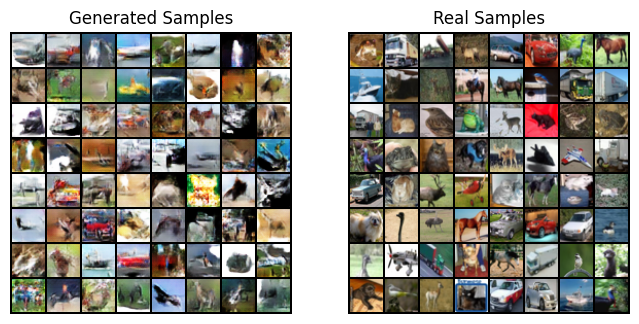

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


real:   0%|          | 0/10000 [00:00<?, ?it/s]

IS 3.65 ± 0.04


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


FID 54.68


In [ ]:
import importlib.util, subprocess, sys, os, shutil, torch, random, math
def need(mod, pkg):
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

need("torchmetrics", "torchmetrics[image]")
need("torch_fidelity", "torch-fidelity")
need("pytorch_fid", "pytorch-fid")
need("tqdm", "tqdm")

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torchmetrics.image.inception import InceptionScore
from pytorch_fid.fid_score import calculate_fid_given_paths
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt, torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

if not (os.environ.get("COLAB_GPU") and os.environ["COLAB_GPU"]):
    raise SystemExit("Switch Colab to GPU and RESTART the runtime.")

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# Configuration parameters
cfg = dict(
    batch=128,
    workers=2,
    nz=100,
    ngf=64,
    ndf=64,
    epochs=25,
    lr=2e-4,
    beta1=0.5,
    real_label=0.9,
    fid_samples=10_000
    )
torch.manual_seed(1337); random.seed(1337)

# Initialize weights following the DCGAN paper
def init_w(m):
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0, 0.02)

def save_flat(imgs, root, start):
    root.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(imgs):
        utils.save_image(img, root/f"{start+i:05d}.png",
                         normalize=True, value_range=(-1,1))

tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])
ds = datasets.CIFAR10("./data", download=True, transform=tx)
fixed_real, _ = next(iter(DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)))

dl = DataLoader(ds, batch_size=cfg["batch"], shuffle=True,
                num_workers=cfg["workers"], persistent_workers=True,
                drop_last=True, pin_memory=True)

# Define Generator network (DCGAN architecture)
class G(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.ConvTranspose2d(cfg["nz"], cfg["ngf"]*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*4), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*4, cfg["ngf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*2), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*2, cfg["ngf"], 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"], 3, 4, 2, 1, bias=False),
            nn.Tanh())
    def forward(s, z): return s.main(z)

# Define Discriminator network (DCGAN architecture)
class D(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.Conv2d(3, cfg["ndf"], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"], cfg["ndf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*2, cfg["ndf"]*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
    def forward(s,x): return s.main(x).view(-1)

G,D = G().to(device).apply(init_w), D().to(device).apply(init_w)
crit = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
optD = optim.Adam(D.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
fixed_noise = torch.randn(64, cfg["nz"], 1, 1, device=device)

out = Path("dcgan_out"); out.mkdir(exist_ok=True)
fake_dir, real_dir = out/"fake", out/"real"
for p in (fake_dir, real_dir): shutil.rmtree(p, ignore_errors=True)

real_lbl = torch.full((cfg["batch"],), cfg["real_label"], device=device)
fake_lbl = torch.zeros(cfg["batch"], device=device)

G_losses = []
D_losses = []

# Training phase
for ep in range(1, cfg["epochs"]+1):
    D_sum, G_sum = 0, 0
    for real,_ in tqdm(dl, leave=False, desc=f"Ep {ep}/{cfg['epochs']}"):
        bs = real.size(0); real = real.to(device)

        # Train Discriminator
        D.zero_grad(set_to_none=True)
        z = torch.randn(bs, cfg["nz"],1,1,device=device)
        fake = G(z)
        lossD = crit(D(real), real_lbl[:bs]) + crit(D(fake.detach()), fake_lbl[:bs])
        lossD.backward(); optD.step()

        # Train Generator
        G.zero_grad(set_to_none=True)
        lossG = crit(D(fake), real_lbl[:bs])
        lossG.backward(); optG.step()

        D_sum += lossD.item(); G_sum += lossG.item()

    print(f"Epoch [{ep}/25] | D {D_sum/len(dl):.3f} | G {G_sum/len(dl):.3f}")

    D_losses.append(D_sum / len(dl))
    G_losses.append(G_sum / len(dl))

    with torch.no_grad():
        grid_fake = G(fixed_noise).cpu()
        utils.save_image(grid_fake, out/f"fake_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(fixed_real, out/f"real_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

# Fake image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Generated Samples")
plt.imshow(utils.make_grid(grid_fake, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0))
plt.axis("off")

# Real image
plt.subplot(1, 2, 2)
plt.title("Real Samples")
plt.imshow(utils.make_grid(fixed_real, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0))
plt.axis("off")
plt.show()

# Evaluate model using IS and FID
metric = InceptionScore(normalize=True).to(device)
saved = 0
with torch.no_grad():
    while saved < cfg["fid_samples"]:
        chunk = min(cfg["batch"], cfg["fid_samples"]-saved)
        imgs = G(torch.randn(chunk, cfg["nz"],1,1,device=device)).cpu()
        save_flat(imgs, fake_dir, saved)
        metric.update(imgs.to(device)); saved += imgs.size(0)

for i in tqdm(range(cfg["fid_samples"]), desc="real"):
    save_flat(ds[i][0].unsqueeze(0), real_dir, i)

# Report final scores
is_mean, is_std = metric.compute()
print(f"IS {is_mean:.2f} ± {is_std:.2f}")
fid = calculate_fid_given_paths([str(real_dir), str(fake_dir)], batch_size=128, device=device, dims=2048)
print(f"FID {fid:.2f}")

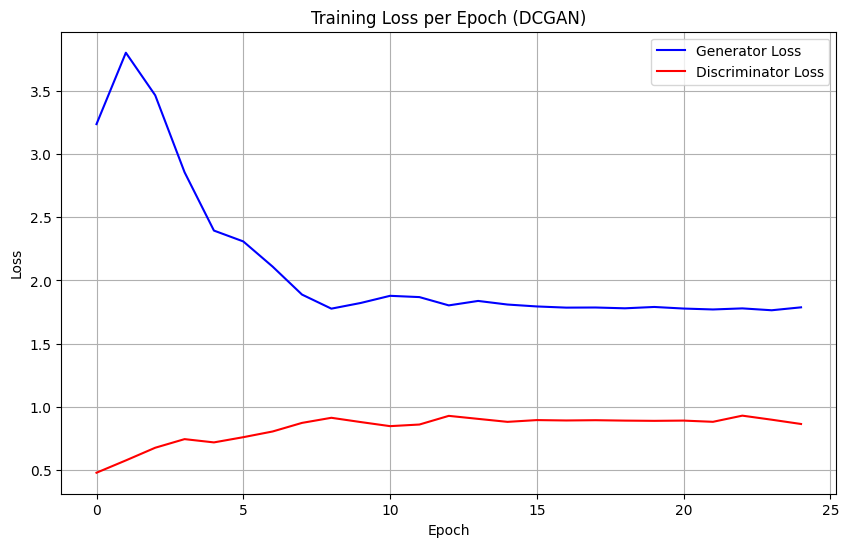

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(G_losses, label="Generator Loss", color="blue")
plt.plot(D_losses, label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch (DCGAN)")
plt.legend()
plt.grid(True)
plt.show()